# Dev notebook for updates

`No development at the moment`

In [1]:
import numpy as np
from dmrg.MPS import MPS 
from dmrg.MPO import MPO_TFI
from dmrg.cont import CONT
from dmrg.dmrg import dmrg
from dmrg.obs import observables

import matplotlib.pyplot as plt

### Class 

### Test

100


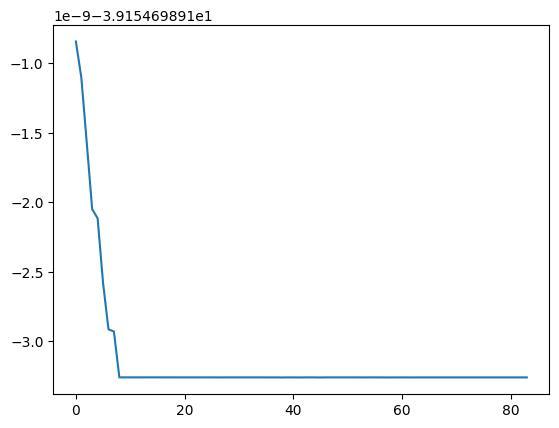

In [2]:
L = 21
mps = MPS(L)
h = MPO_TFI(.1,1,pol='tot')
cont = CONT(mps,h) 
sys = dmrg(cont,chi=2)
obs = observables(mps)
# En0 = sys.infinite()
mps.random()
cont.random()


sys.chi = 100
print(sys.chi)
EE = []
# EE.append(En0[-1])
EE_pre = []
k = 0 
# print(En0)

for site,dir in mps.first_sweep():
    En,_ = sys.step2sites(site,dir=dir)
    # EE.append(En)

for site,dir in mps.sweep():
    En,_ = sys.step2sites(site,dir=dir)
    EE.append(En)

for site,dir in mps.sweep():
    En,_ = sys.step2sites(site,dir=dir)
    EE.append(En)

Z = []
for i in range(2,L-2):
    if i == 2:
        o1,o2 = obs.bound_left(i-1,h.Z)
        Z += [o1.real,o2.real]
    En_fin,_ =sys.step2sites(i,dir='r',stage='Final')
    EE.append(En)
    Z += [obs.single_site(i,h.Z).real]
    if i == L-3:
        o1,o2 = obs.bound_right(i+1,h.Z)
        Z += [o1.real,o2.real]

plt.plot(EE[1:])

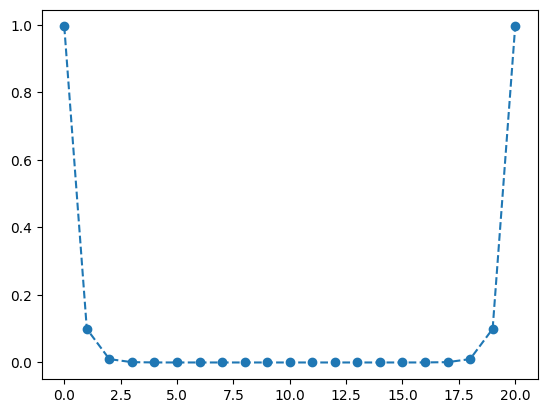

In [3]:
plt.plot(Z,'o--')

In [ ]:
from itertools import product
dim = [4,2,2]
Id4 = np.identity(4)
res = np.zeros((2,2,4))
ranges = [range(d) for d in dim]
for i in product(*ranges):
    res[i[0],i[1],i[2]] =Id4[i[0]i[1]i[2]]

IndexError: index 4 is out of bounds for axis 0 with size 4

In [5]:
d=4
a = np.reshape(np.identity(d**2)[:,:d],(d,d,d))
np.tensordot(a,a,((0,1),(0,1)))

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])